## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [4]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from evaluation_scripts.label_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset prep: B10

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Sub-Patches

In [6]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 10, 5, 5]), torch.Size([867, 7, 10, 5, 5]))

Get field numbers and co-ordinates as string

In [7]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [8]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)  # (N, T, C, H, W) -> (N, C, T, H, W)


## Architecture 1: Autoencoder with 1D Time Convolution

### Architecture

Input Data: ( N x C x D x H x W )

In [8]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(6400, 6400, kernel_size=time_steps, stride=1, padding=0, groups=800)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6400, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 6400)  # Matches shape before Conv1D

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(6400, 6400, kernel_size=time_steps, stride=1, padding=0, groups=6400)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        # print("x shape initial: ",x.shape)
        x = x.view(b, c * h * w, t)                     # (batch, 800, time)

        # print(f"Shape before 1D Conv: {x.shape}") 
        x = self.conv1d(x)                              # Time aggregation
        # print(f"Shape after 1D Conv: {x.shape}")      # (batch, 800, 1)

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x) 

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        x = x.view(b, 6400, 1)  
        x = self.deconv1d(x) 
        # print(f"Shape after Deconv1D: {x.shape}")  # (batch, 800, time_steps)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)  
        # print("x before unflatten", x.shape)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)  

        return z, x_reconstructed


### Training

In [9]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=800)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=6400)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deco

In [10]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50, Train Loss: 0.003137, Test Loss: 0.001212
Epoch 2/50, Train Loss: 0.000837, Test Loss: 0.000800
Epoch 3/50, Train Loss: 0.000663, Test Loss: 0.000712
Epoch 4/50, Train Loss: 0.000424, Test Loss: 0.000617
Epoch 5/50, Train Loss: 0.000343, Test Loss: 0.000394
Epoch 6/50, Train Loss: 0.000274, Test Loss: 0.000430
Epoch 7/50, Train Loss: 0.000253, Test Loss: 0.000451
Epoch 8/50, Train Loss: 0.000241, Test Loss: 0.000335
Epoch 9/50, Train Loss: 0.000232, Test Loss: 0.000267
Epoch 10/50, Train Loss: 0.000221, Test Loss: 0.000661
Epoch 11/50, Train Loss: 0.000211, Test Loss: 0.000411
Epoch 12/50, Train Loss: 0.000194, Test Loss: 0.000233
Epoch 13/50, Train Loss: 0.000187, Test Loss: 0.000186
Epoch 14/50, Train Loss: 0.000182, Test Loss: 0.000611
Epoch 15/50, Train Loss: 0.000206, Test Loss: 0.000222
Epoch 16/50, Train Loss: 0.000169, Test Loss: 0.000179
Epoch 17/50, Train Loss: 0.000163, Test Loss: 0.000181
Epoch 18/50, Train Loss: 0.000151, Test Loss: 0.000161
Epoch 19/50, Train 

### Evaluation

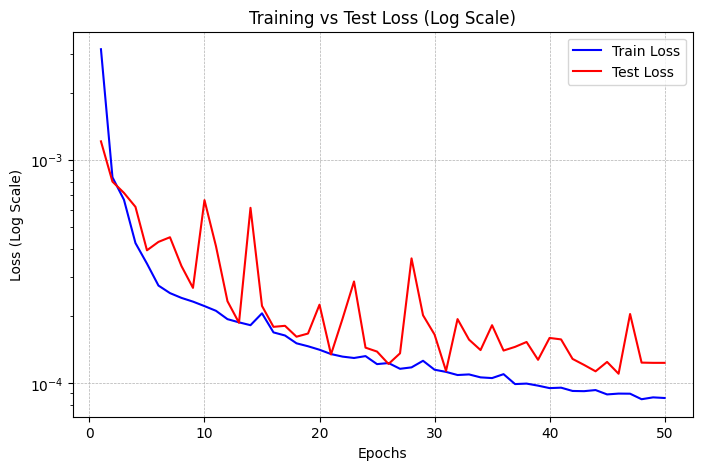

In [11]:
plot_loss_log_scale(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [12]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [15]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=21)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [16]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [17]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.5245901639344263
              precision    recall  f1-score   support

           0       0.44      0.42      0.43        26
           1       0.58      0.60      0.59        35

    accuracy                           0.52        61
   macro avg       0.51      0.51      0.51        61
weighted avg       0.52      0.52      0.52        61



Clustering Accuracy

In [18]:
acc, precision_per_class, recall_per_class, f1_per_class = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)

Accuracy: 0.5245901639344263
Precision: [0.44       0.58333333]
Recall: [0.42307692 0.6       ]
F1-score: [0.43137255 0.5915493 ]


## Architecture 2: Autoencoder with Residual Connections

### Architecture

## Architecture 3: Conv2D with Time as Channels

In [32]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)      # Reshape to treat time steps as channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        # Reshape back to spatial dimensions
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed


### Training

In [33]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoderVariant(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [34]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50, Train Loss: 0.006740, Test Loss: 0.002242
Epoch 2/50, Train Loss: 0.001546, Test Loss: 0.001516
Epoch 3/50, Train Loss: 0.001200, Test Loss: 0.001747
Epoch 4/50, Train Loss: 0.001044, Test Loss: 0.001299
Epoch 5/50, Train Loss: 0.000847, Test Loss: 0.001144
Epoch 6/50, Train Loss: 0.000773, Test Loss: 0.000704
Epoch 7/50, Train Loss: 0.000690, Test Loss: 0.000846
Epoch 8/50, Train Loss: 0.000676, Test Loss: 0.001273
Epoch 9/50, Train Loss: 0.000649, Test Loss: 0.000709
Epoch 10/50, Train Loss: 0.000546, Test Loss: 0.000575
Epoch 11/50, Train Loss: 0.000480, Test Loss: 0.000588
Epoch 12/50, Train Loss: 0.000429, Test Loss: 0.000487
Epoch 13/50, Train Loss: 0.000411, Test Loss: 0.000525
Epoch 14/50, Train Loss: 0.000402, Test Loss: 0.000459
Epoch 15/50, Train Loss: 0.000381, Test Loss: 0.000533
Epoch 16/50, Train Loss: 0.000368, Test Loss: 0.000354
Epoch 17/50, Train Loss: 0.000323, Test Loss: 0.000358
Epoch 18/50, Train Loss: 0.000309, Test Loss: 0.000438
Epoch 19/50, Train 

### Evaluation

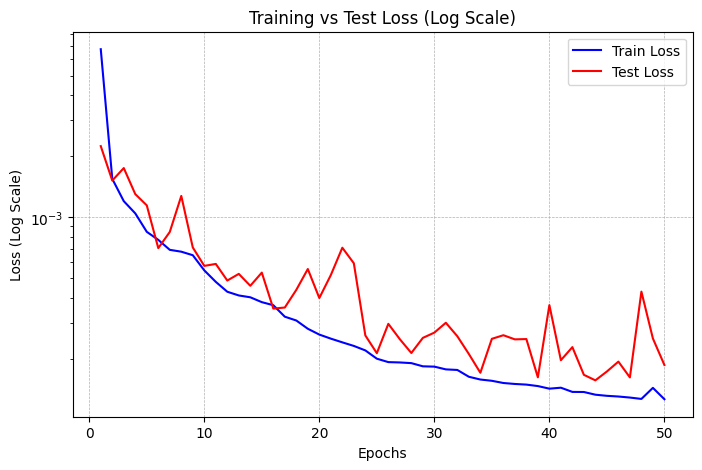

In [35]:
plot_loss_log_scale(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [36]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [37]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=22)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [38]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [39]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.6229508196721312
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        26
           1       0.65      0.74      0.69        35

    accuracy                           0.62        61
   macro avg       0.61      0.60      0.60        61
weighted avg       0.62      0.62      0.62        61



Clustering Accuracy

In [40]:
acc, precision_per_class, recall_per_class, f1_per_class = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)

Accuracy: 0.6229508196721312
Precision: [0.57142857 0.65      ]
Recall: [0.46153846 0.74285714]
F1-score: [0.5106383  0.69333333]


## Architecture 4: Variational Autoencoder

In [41]:
class Conv3DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)  # Mean
        self.fc_logvar = nn.Linear(512, latent_size)  # Log Variance

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        x = x.view(b, c * h * w, t)
        x = self.conv1d(x)  # Time aggregation

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        x = x.view(b, 256 * patch_size * patch_size, 1)
        x = self.deconv1d(x)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)

        return mu, log_var, z, x_reconstructed

### Training

In [42]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DVAE(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kerne

In [43]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses  = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 363.3264, Train KL Loss: 0.7812
  Test Recon Loss: 348.4294, Test KL Loss: 0.0585
Epoch 2/50
  Train Recon Loss: 294.7297, Train KL Loss: 3.3737
  Test Recon Loss: 305.5763, Test KL Loss: 23.7849
Epoch 3/50
  Train Recon Loss: 246.2527, Train KL Loss: 24.1674
  Test Recon Loss: 232.1358, Test KL Loss: 27.8845
Epoch 4/50
  Train Recon Loss: 226.2915, Train KL Loss: 32.1571
  Test Recon Loss: 231.0629, Test KL Loss: 32.8368
Epoch 5/50
  Train Recon Loss: 222.2520, Train KL Loss: 34.1397
  Test Recon Loss: 222.2191, Test KL Loss: 38.2368
Epoch 6/50
  Train Recon Loss: 219.8270, Train KL Loss: 34.7683
  Test Recon Loss: 219.1722, Test KL Loss: 33.8336
Epoch 7/50
  Train Recon Loss: 217.1494, Train KL Loss: 35.2836
  Test Recon Loss: 231.0212, Test KL Loss: 33.4131
Epoch 8/50
  Train Recon Loss: 217.6331, Train KL Loss: 35.4432
  Test Recon Loss: 278.5249, Test KL Loss: 34.5695
Epoch 9/50
  Train Recon Loss: 216.8927, Train KL Loss: 35.9222
  Test Recon Loss: 

### Evaluation

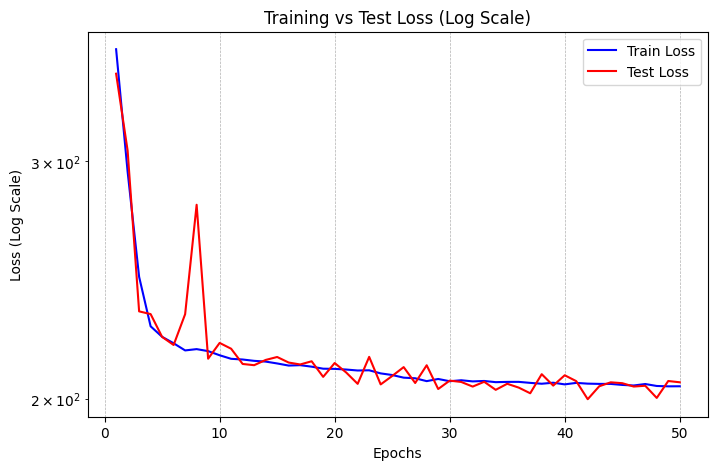

In [44]:
plot_loss_log_scale(train_recon_losses, test_recon_losses)

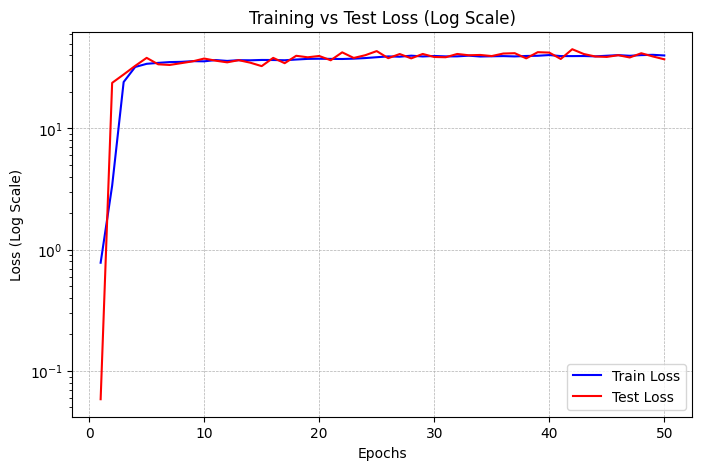

In [45]:
plot_loss_log_scale(train_kl_losses, test_kl_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [46]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [47]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=25)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [48]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [49]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.5081967213114754
              precision    recall  f1-score   support

           0       0.43      0.46      0.44        26
           1       0.58      0.54      0.56        35

    accuracy                           0.51        61
   macro avg       0.50      0.50      0.50        61
weighted avg       0.51      0.51      0.51        61



Clustering Accuracy

In [50]:
acc, precision_per_class, recall_per_class, f1_per_class = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)

Accuracy: 0.5081967213114754
Precision: [0.42857143 0.57575758]
Recall: [0.46153846 0.54285714]
F1-score: [0.44444444 0.55882353]


## Architecture 5: Variational Autoencoder with time as channels

In [51]:
class Conv2DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)  # Mean
        self.fc_logvar = nn.Linear(512, latent_size)  # Log Variance

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)      # Reshape to treat time steps as channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        # Reshape back to spatial dimensions
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return mu, log_var, z, x_reconstructed

### Training

In [52]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=16
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DVAE(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kerne

In [53]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses  = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 377.2919, Train KL Loss: 1.1380
  Test Recon Loss: 330.6438, Test KL Loss: 1.1119
Epoch 2/50
  Train Recon Loss: 267.8142, Train KL Loss: 15.8532
  Test Recon Loss: 299.0523, Test KL Loss: 38.1530
Epoch 3/50
  Train Recon Loss: 226.3596, Train KL Loss: 34.3021
  Test Recon Loss: 325.3786, Test KL Loss: 30.5450
Epoch 4/50
  Train Recon Loss: 221.9986, Train KL Loss: 35.7491
  Test Recon Loss: 219.1186, Test KL Loss: 36.1772
Epoch 5/50
  Train Recon Loss: 219.1733, Train KL Loss: 36.2168
  Test Recon Loss: 218.3987, Test KL Loss: 37.5001
Epoch 6/50
  Train Recon Loss: 218.2864, Train KL Loss: 36.6864
  Test Recon Loss: 208.4547, Test KL Loss: 40.4486
Epoch 7/50
  Train Recon Loss: 216.9472, Train KL Loss: 37.3135
  Test Recon Loss: 241.2429, Test KL Loss: 37.2222
Epoch 8/50
  Train Recon Loss: 215.3499, Train KL Loss: 36.8508
  Test Recon Loss: 216.8725, Test KL Loss: 36.3642
Epoch 9/50
  Train Recon Loss: 213.8745, Train KL Loss: 37.5089
  Test Recon Loss:

### Evaluation

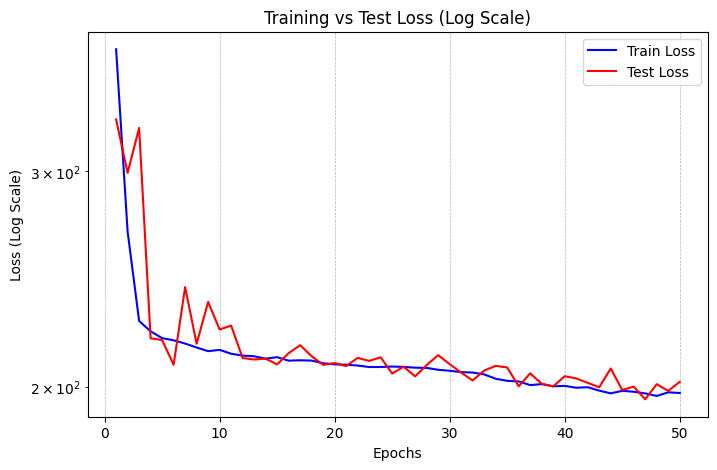

In [54]:
plot_loss_log_scale(train_recon_losses, test_recon_losses)

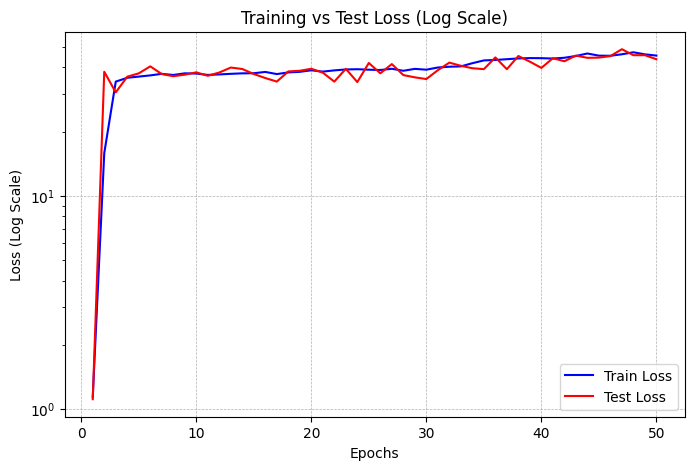

In [55]:
plot_loss_log_scale(train_kl_losses, test_kl_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [56]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [57]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=26)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [58]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [59]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.5081967213114754
              precision    recall  f1-score   support

           0       0.40      0.31      0.35        26
           1       0.56      0.66      0.61        35

    accuracy                           0.51        61
   macro avg       0.48      0.48      0.48        61
weighted avg       0.49      0.51      0.50        61



Clustering Accuracy

In [60]:
acc, precision_per_class, recall_per_class, f1_per_class = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)

Accuracy: 0.5081967213114754
Precision: [0.4        0.56097561]
Recall: [0.30769231 0.65714286]
F1-score: [0.34782609 0.60526316]
